In [37]:
# unresolved username ownership
# poopdwogga


In [38]:
def load_txt(path):
    with open(path, "r", encoding="utf-8") as f:
        return f.read()

cpvp_lt_mct_data = load_txt("result_data/cpvp_lt_mct.txt")
cpvp_mct_data    = load_txt("result_data/cpvp_mct.txt")

mace_mct_data    = load_txt("result_data/mace_mct.txt")

uhc_mct_data     = load_txt("result_data/uhc_mct.txt")
uhc_pvpt_data    = load_txt("result_data/uhc_pvpt.txt")

axe_mct_data     = load_txt("result_data/axe_mct.txt")

smp_mct_data     = load_txt("result_data/smp_mct.txt")
smp_pvpt_data    = load_txt("result_data/smp_pvpt.txt")

data = (cpvp_lt_mct_data + cpvp_mct_data)
#data = mace_mct_data
#data = (uhc_pvpt_data + uhc_mct_data)

In [39]:
import re

data = data.lower().strip()
data = re.sub("won", "", data)
data = re.sub("lost", "", data)
data = "\n".join([s for s in data.split("\n") if s]) # remove empty lines
data = "\n".join([s for s in data.split("\n") if not (s.__contains__("strikes") or s.__contains__("fight") or s.__contains__("eval"))]) # Remove lines that contain fight information like "HT3 Fights:" or "LT1 Fights"
data = "\n".join([s for s in data.split("\n") if not (s.__contains__("evaluation"))]) # Remove lines that say "passed evaluation"
data = re.sub(r"^@[^-]+-\s*([^-]+)\s*-.*$", r"\1", data, flags=re.MULTILINE) # removes the discord username and the promotion / demotion message and leaves only the username: "@marlow - marlowww - placed back high tier 1" => "marlowww"

lines = data.split("\n") # remove the authors of each discord message from the string
data = "\n".join(
    line for i, line in enumerate(lines)
    if not (i + 1 < len(lines) and lines[i + 1].strip() == "—")
)

#print(data)

In [ ]:
from datetime import datetime

# Turn the string into an array of messages, where each message is itself an array that contains each individual line
messages = [
    [line.strip() for line in message.strip().split("\n") if line.strip()]
    for message in data.split("—") if message.strip()
]

# Define a function to extract and parse the date from the first line of each message
def parse_date(message):
    date_str = message[0].split(",")[0].strip() + "," + message[0].split(",")[1]
    return datetime.strptime(date_str, "%d/%m/%Y, %H:%M")

# Sort the messages in ascending order by date
messages.sort(key=parse_date)

# Keep first two entries fixed, reverse everything after
for i, m in enumerate(messages):
    if len(m) > 2:
        messages[i] = m[:2] + m[2:][::-1]

# Debug print
for m in messages:
    print(m)
#print(messages)

In [ ]:
allplayers = set()

for result in messages:
  if len(result) <= 1:
    print(result)
  else:
    allplayers.add(result[1])
  for match in result[2:]:
    allplayers.add(match[4:])

print(allplayers)
print(len(allplayers))

In [42]:
from datetime import datetime, timedelta
from collections import deque
from typing import Dict, List, Tuple

FT4_GM = True

DEFAULT_ELO = 2000
K = 70 if FT4_GM else 100
DATE_FORMAT = "%d/%m/%Y, %H:%M"
DUPLICATE_WINDOW = timedelta(days=30)
COUNT_INDIVIDUAL_ROUNDS = False
BASE_WEIGHT = 0.1
ITERATION_COUNT = 10
RESET_DIVISOR = 1.8


# --- ELO helpers --------------------------------------------------------

def expected_score(r1: float, r2: float) -> float:
    return 1 / (1 + 10 ** ((r2 - r1) / 400))


def update_elo(r1: float, r2: float, score: float) -> Tuple[float, float]:
    e1 = expected_score(r1, r2)
    e2 = expected_score(r2, r1)
    return r1 + K * (score - e1), r2 + K * ((1 - score) - e2)


def parse_match_result(result: str) -> Tuple[str, int, int]:
    """Parse '4-2 opponent' → ('opponent', 4, 2)"""
    parts = result.strip().split()
    if len(parts) < 2 or '-' not in parts[0]:
        return None, 0, 0
    try:
        wins, losses = map(int, parts[0].split('-'))
        return parts[1].lower(), wins, losses
    except:
        return None, 0, 0


# --- Main processing ----------------------------------------------------

def process_messages(messages: List[List[str]]) -> Dict[str, dict]:

    players: Dict[str, dict] = {}

    # Pre-parse all dates once (major performance boost)
    processed_msgs = []
    for entry in messages:
        if len(entry) < 2:
            continue
        date = datetime.strptime(entry[0], DATE_FORMAT)
        player = entry[1].lower()
        processed_msgs.append((date, player, entry[2:]))

    # Duplicate tracking
    recent_matches = deque()
    duplicate_set = set()

    for _ in range(ITERATION_COUNT):

        # Reset duplicates per iteration
        recent_matches.clear()
        duplicate_set.clear()

        # Reset players soft-elo and history
        for name, data in players.items():
            data["history"].clear()

            if data["elo"] > DEFAULT_ELO:
                data["elo"] = DEFAULT_ELO + (data["elo"] - DEFAULT_ELO) / RESET_DIVISOR
            else:
                data["elo"] = data["elo"]

            data["peak"] = data["elo"]


        # Process each message
        for date, player, match_list in processed_msgs:

            if player not in players:
                players[player] = {"elo": DEFAULT_ELO, "peak": DEFAULT_ELO, "history": []}

            players[player]["history"].append((date, players[player]["elo"]))

            # Clean out old matches (O(1) amortized)
            while recent_matches and date - recent_matches[0][0] > DUPLICATE_WINDOW:
                old = recent_matches.popleft()
                key = (old[1], old[2], old[3], old[4])
                rev = (old[1], old[2], old[4], old[3])
                duplicate_set.discard(key)
                duplicate_set.discard(rev)

            for raw_match in match_list:

                opponent, wins, losses = parse_match_result(raw_match)
                if not opponent:
                    continue

                if opponent not in players:
                    players[opponent] = {"elo": DEFAULT_ELO, "peak": DEFAULT_ELO, "history": []}

                players[opponent]["history"].append((date, players[opponent]["elo"]))

                # Determine sorted pair
                p1, p2 = sorted([player, opponent])
                key = (p1, p2, wins, losses)
                rev = (p1, p2, losses, wins)

                # Duplicate detection in O(1)
                if key in duplicate_set or rev in duplicate_set:
                    continue

                # Store in the recent deque + set
                recent_matches.append((date, p1, p2, wins, losses))
                duplicate_set.add(key)
                duplicate_set.add(rev)

                # --- ELO Update ------------------------------------------------
                r1, r2 = players[player]["elo"], players[opponent]["elo"]

                if COUNT_INDIVIDUAL_ROUNDS:
                    for _ in range(wins):
                        r1, r2 = update_elo(r1, r2, 1)
                    for _ in range(losses):
                        r1, r2 = update_elo(r1, r2, 0)

                else:
                    total = wins + losses
                    if total == 0:
                        score = 0.5
                    else:
                        ratio = wins / total
                        if wins > losses:
                            score = BASE_WEIGHT + (1 - BASE_WEIGHT) * ratio
                        elif losses > wins:
                            score = (1 - BASE_WEIGHT) * ratio
                        else:
                            score = 0.5

                    r1, r2 = update_elo(r1, r2, score)

                # Apply results
                players[player]["elo"] = r1
                players[opponent]["elo"] = r2

                players[player]["peak"] = max(players[player]["peak"], r1)
                players[opponent]["peak"] = max(players[opponent]["peak"], r2)

                players[player]["history"].append((date, r1))
                players[opponent]["history"].append((date, r2))

    return players


In [43]:
from datetime import datetime, timedelta
from typing import Dict

def print_leaderboard(
    players: Dict[str, dict],
    sort_by: str = "elo",
    top_n: int = 100000,
    inclTier: bool = False,
    active_within_days: int = None,
    up_to_date: str = None,
):
    """
    Prints the ELO leaderboard.

    - up_to_date: optional string in DATE_FORMAT (e.g. "15/07/2025, 00:00").
                 If provided, the leaderboard will be a snapshot "as of" that datetime.
    - active_within_days: if provided, filters players who have not played within the
                 last `active_within_days` days relative to the snapshot (or now if no snapshot).
    - sort_by: "elo" or "peak" (or any key present in the player snapshot dict).
    """
    now = datetime.now()
    cutoff = None
    if up_to_date:
        cutoff = datetime.strptime(up_to_date, DATE_FORMAT)

    filtered_players = {}

    for name, data in players.items():
        history = data.get("history", [])
        if not history:
            # No history at all -> skip (no known rating)
            continue

        # Build a snapshot for this player either up to cutoff or the full current data
        if cutoff:
            # Keep only last ELO per datetime
            history_by_time = {}
            for d, e in history:
                history_by_time[d] = e  # later entries overwrite earlier ones at same timestamp

            # only include timestamps <= cutoff
            past_entries = [(d, e) for d, e in history_by_time.items() if d <= cutoff]
            if not past_entries:
                continue

            # latest entry
            latest_date, latest_elo = max(past_entries, key=lambda x: x[0])

            # peak up to that point
            peak_up_to = max(e for _, e in past_entries)

            player_snapshot = {
                "elo": latest_elo,
                "peak": peak_up_to,
                "history": past_entries,
            }
            # time reference for active-within calculation is the cutoff
            activity_reference = cutoff
        else:
            # use current data as-is
            player_snapshot = {
                "elo": data.get("elo", DEFAULT_ELO),
                "peak": data.get("peak", DEFAULT_ELO),
                "history": history,
            }
            activity_reference = now

        # Apply active_within_days relative to activity_reference (cutoff or now)
        if active_within_days is not None and player_snapshot.get("history"):
            last_match_date = max(date for date, _ in player_snapshot["history"])
            if (activity_reference - last_match_date) > timedelta(days=active_within_days):
                continue  # inactive relative to reference

        filtered_players[name] = player_snapshot

    # Ensure sort_by exists in snapshot, fallback to 'elo'
    def sort_key(item):
        _, pdata = item
        return pdata.get(sort_by, pdata.get("elo", DEFAULT_ELO))

    sorted_players = sorted(filtered_players.items(), key=sort_key, reverse=True)

    # Print header (show cutoff if present)
    header_date = f" (as of {cutoff.strftime(DATE_FORMAT)})" if cutoff else ""
    print(f"\nLeaderboard{header_date}")
    print(f"{'Rank':<5}{'Player':<20}{'ELO':>8}{'Peak':>8}{'Tier':>8}{'PeakTier':>10}")
    print("-" * 65)

    # helper for tier
    def tier_for(elo_val):
        if elo_val > 2500: return "HT1"
        if elo_val > 2350: return "LT1"
        if elo_val > 2250: return "HT2"
        if elo_val > 2100: return "LT2"
        return "HT3"

    for i, (name, pdata) in enumerate(sorted_players[:top_n], start=1):
        elo = pdata["elo"]
        peak = pdata["peak"]
        if inclTier:
            tier = tier_for(elo)
            peak_tier = tier_for(peak)
            print(f"{i:<5}{name:<20}{elo:>8.0f}{peak:>8.0f}{tier:>8}{peak_tier:>10}")
        else:
            if (sort_by == "peak"):
                print(f"{i:<5}{name:<20}{peak:>8.0f}")
            else:
                print(f"{i:<5}{name:<20}{elo:>8.0f}{peak:>8.0f}")


In [44]:
players = process_messages(messages)

In [45]:
#print_leaderboard(players, sort_by="elo", up_to_date="01/09/2024, 00:00", active_within_days=120, inclTier=True)
#print_leaderboard(players, sort_by="peak", active_within_days=None, inclTier=False)
print_leaderboard(players, sort_by="elo", active_within_days=40, inclTier=False)

#for player, data in players.items():
   #if player=="gallerywalk" or player=="dwggo":
      #print(player)
      #print(data["history"])
      #for a in data["history"]:  # last 5 entries
         #print(a)



Leaderboard
Rank Player                   ELO    Peak    Tier  PeakTier
-----------------------------------------------------------------
1    marlowww                2627    2627
2    kingd3fault             2425    2458
3    evantii                 2389    2428
4    gallerywalk             2386    2408
5    k1rbe                   2374    2388
6    pomojz                  2335    2372
7    c1utch                  2319    2326
8    thiefed                 2311    2342
9    nopzdaflopper           2309    2409
10   dwggo                   2278    2426
11   cowarted                2267    2356
12   moezxf                  2244    2294
13   zfay                    2243    2274
14   legionofboom            2233    2233
15   n1tr0blade              2226    2288
16   kqle_                   2223    2338
17   godlygobber             2220    2246
18   kyuley                  2206    2206
19   xmexus                  2193    2242
20   dwogga                  2189    2309
21   opaban          

In [ ]:
import requests
import time

url = "https://mctiers.com/api/tier/vanilla?count=50&from="

lt3, ht3, lt2, ht2, lt1, ht1 = [], [], [], [], [], []

def safe_get_json(url):
    """Fetch JSON safely. Return None if it fails."""
    try:
        response = requests.get(url)
        if response.status_code != 200:
            print(f"[ERROR] Status {response.status_code} for: {url}")
            return None

        return response.json()  # might still fail
    except Exception as e:
        print(f"[ERROR] JSON decode failed for: {url}")
        return None


for i in range(160):
    full_url = f"{url}{50*i}"
    print(f"Fetching page {i}...")

    rankings = safe_get_json(full_url)

    if rankings is None:  # skip failed pages
        continue

    # Process the data
    for tierindex in range(3):  # 0 = T1, 1 = T2, 2 = T3
        tier_players = rankings["rankings"][tierindex]

        for playerranking in tier_players:
            playeruuid = playerranking[0]
            pos = playerranking[1]  # 0=high, 1=low

            playername = rankings["players"][playeruuid]["name"].lower()
            #print("  ", playername)

            # Classification logic
            if tierindex == 0:
                (ht1 if pos == 0 else lt1).append(playername)
            elif tierindex == 1:
                (ht2 if pos == 0 else lt2).append(playername)
            elif tierindex == 2:
                (ht3 if pos == 0 else lt3).append(playername)

    time.sleep(0.05)  # avoid rate limiting


print("\nDONE!\n")

print("LT2:", lt2)
print("HT2:", ht2)
print("LT1:", lt1)
print("HT1:", ht1)


# Manual additions
lt2 += ["b1tr0blade", "jeremyoo", "inthedust", "dwogga", "kyuley", "l3poo", "warrpp"]
ht2.append("quelchi")


In [ ]:
def get_elos(player_list, players_dict):
    elos = []
    for name in player_list:
        key = name.lower()
        if key in players_dict:
            elos.append(players_dict[key]["elo"])
        else:
            print(f"Missing player in players_dict: {name}")
    return elos


# Gather data
tier_data = {
    "HT1": get_elos(ht1, players),
    "LT1": get_elos(lt1, players),
    "HT2": get_elos(ht2, players),
    "LT2": get_elos(lt2, players),
    "HT3": get_elos(ht3, players),
    "LT3": get_elos(lt3, players),
    #"all": get_elos(players, players),
}

In [47]:
def print_all_tiers(tier_groups, players_dict):
    for tier_name, player_list in tier_groups.items():
        print(f"{tier_name}:")

        # Build list of [name, elo]
        elo_list = []
        for name in player_list:
            key = name.lower()
            if key in players_dict:
                elo = players_dict[key]["elo"]
                elo_list.append([name, elo])


        # Sort DESC by elo
        elo_list.sort(key=lambda x: x[1], reverse=True)

        # Print nicely
        for name, elo in elo_list:
            print(f"{name:<15}{round(elo):>8}")

        print()  # blank line between tiers

tiers = {
    "HT1": ht1,
    "LT1": lt1,
    "HT2": ht2,
    "LT2": lt2,
    #"HT3": ht3,
    #"LT3": lt3,
}

print_all_tiers(tiers, players)


HT1:
marlowww           2627

LT1:
kingd3fault        2425
evantii            2389
k1rbe              2374

HT2:
gallerywalk        2386
pomojz             2335
c1utch             2319
thiefed            2311
dwggo              2278
cowarted           2267
moezxf             2244
kqle_              2223
godlygobber        2220
quelchi            2136

LT2:
legionofboom       2233
n1tr0blade         2226
N1tr0Blade         2226
kyuley             2206
xmexus             2193
dwogga             2189
opaban             2183
cattonator         2175
cheesegrater2014    2175
keptra             2173
kvrdy              2164
lalekz             2163
pflaw              2156
turrnn             2155
inthedust          2146
andrexw            2144
dandystingray64    2144
cpvpekitten        2143
isolatiion         2123
realfo6y           2120
monwy              2117
qpower             2116
mikeyzz1           2101
l3poo              2096
fllnish            2091
tokenu             2090
ihitcrystal     

C:\Users\Lucac\AppData\Local\Temp\ipykernel_12616\705543090.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


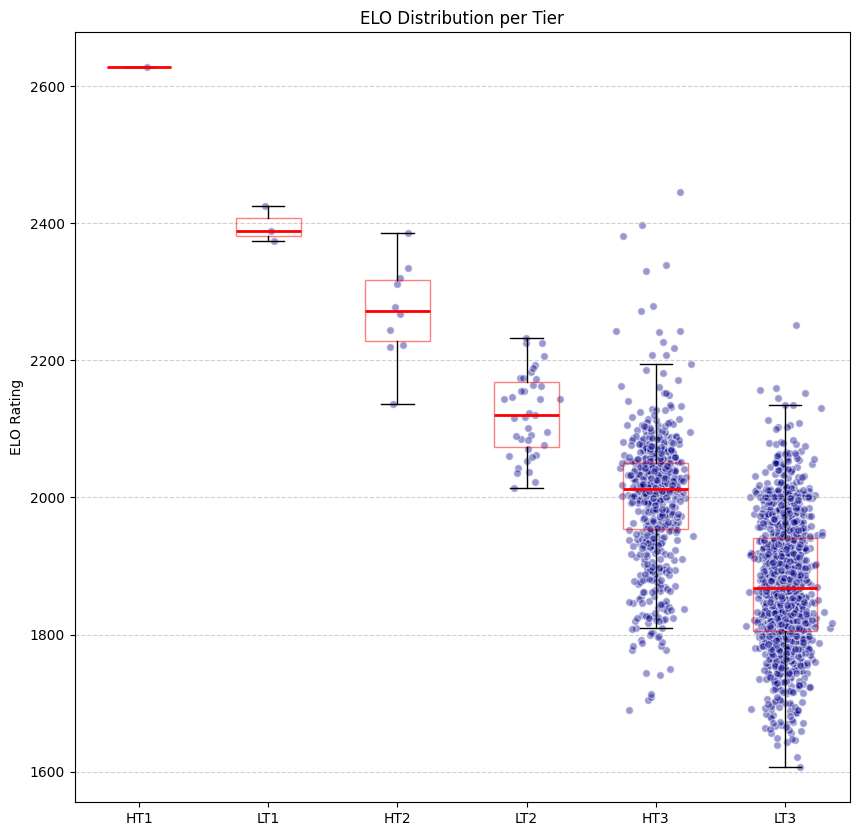

In [55]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
positions = np.arange(1, len(tier_data) + 1)

# Boxplot (no fliers)
plt.boxplot(
    tier_data.values(),
    labels=tier_data.keys(),
    patch_artist=True,
    showfliers=False,
    boxprops=dict(facecolor="none", color="red", alpha = 0.5),
    medianprops=dict(color="red", linewidth=2),
)

# Overlay individual points
for i, (tier, elos) in enumerate(tier_data.items(), start=1):
    jitter = np.random.normal(0, 0.1, size=len(elos))  # add random horizontal offset
    plt.scatter(
        np.full(len(elos), i) + jitter,
        elos,
        alpha=0.4,
        color="darkblue",
        edgecolor="white",
        s=30,
    )

plt.title("ELO Distribution per Tier")
plt.ylabel("ELO Rating")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

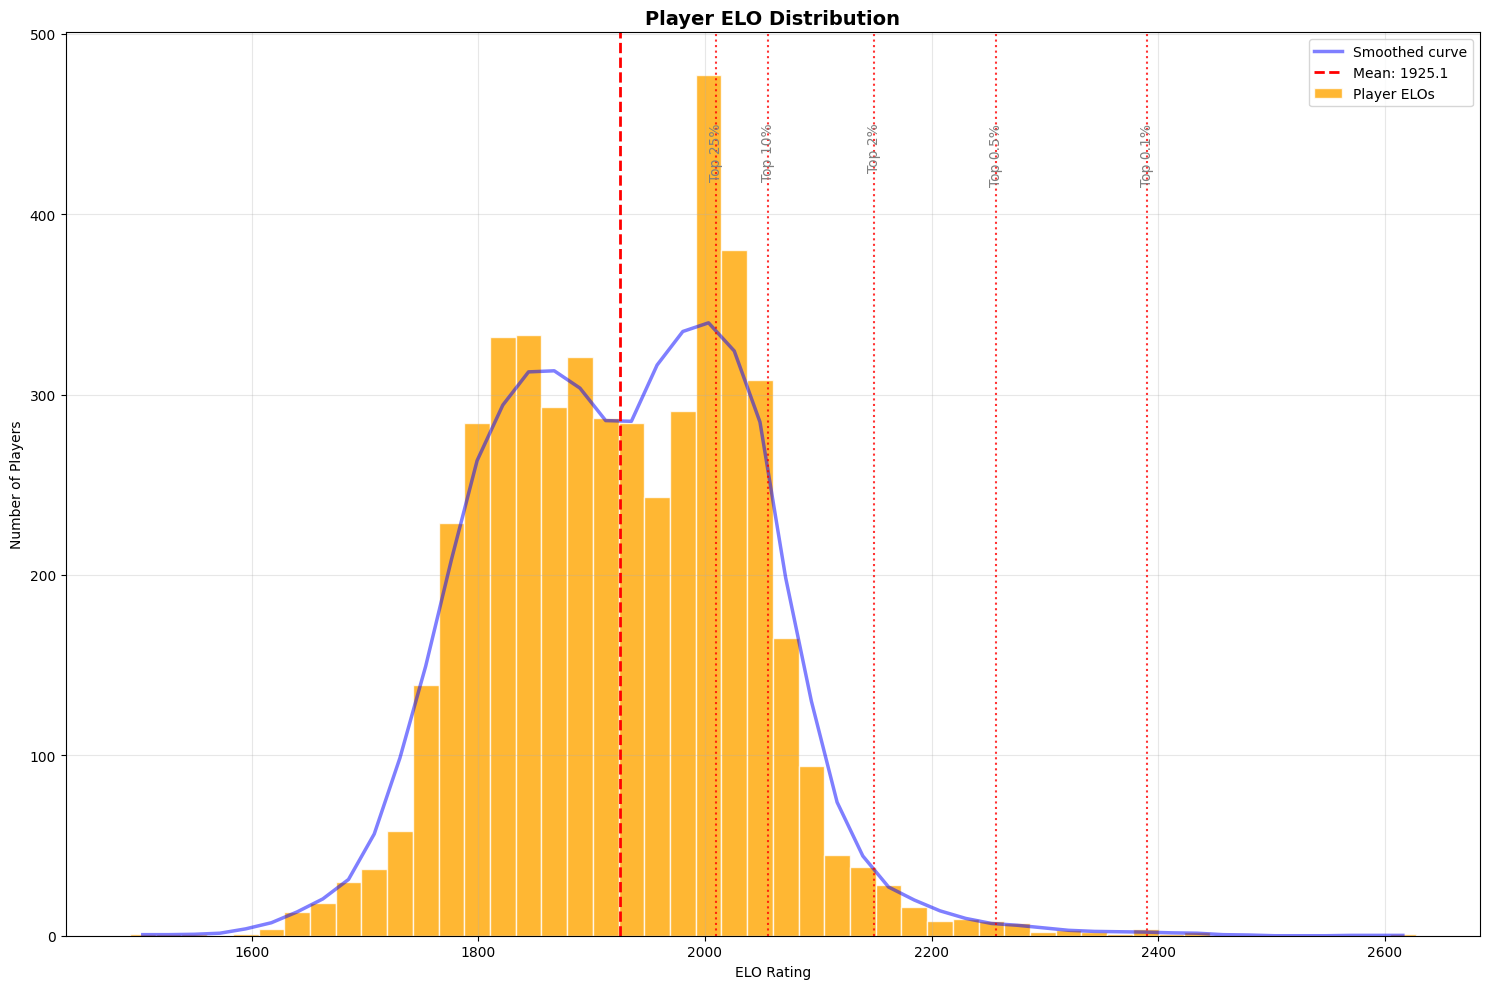

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def plot_elo_distribution(players: dict, bins: int = 40, smooth: bool = True, window: int = 3):
    """
    Plots the ELO distribution of all players with optional smoothing (no SciPy required).

    Args:
        players: dict[str, dict] - player data from process_messages()
        bins: int - number of histogram bins
        smooth: bool - whether to smooth the histogram with a moving average
        window: int - window size for smoothing
    """
    # Collect all ELOs
    elos = np.array([data["elo"] for data in players.values() if "elo" in data])

    if len(elos) == 0:
        print("No ELO data found.")
        return

    # Compute stats
    mean_elo = np.mean(elos)
    median_elo = np.median(elos)


    # Histogram data — now counts, not density
    counts, bin_edges = np.histogram(elos, bins=bins, density=False)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Optional smoothing
    if smooth and len(counts) >= window:
        kernel = np.ones(window) / window
        smooth_counts = np.convolve(counts, kernel, mode='same')
    else:
        smooth_counts = counts

    # Plot
    plt.figure(figsize=(15, 10))

    plt.bar(bin_centers, counts, width=(bin_edges[1] - bin_edges[0]),
            color="orange", alpha=0.8, edgecolor="white", label="Player ELOs")

    if smooth:
        plt.plot(bin_centers, smooth_counts, color="blue", linewidth=2.5, alpha=0.5, label="Smoothed curve")

    # Highlight IQR range
    for i in [75, 90, 98, 99.5, 99.9]:
        t = np.percentile(elos, i)
        plt.axvline(t, color="red", linestyle=":", alpha=0.8)
        plt.text(t, plt.ylim()[1]*0.9, f"Top {round(100-i, 1)}%", rotation=90, va="top", ha="center", fontsize=10, color="gray")

    # Mean and median lines
    plt.axvline(mean_elo, color="red", linestyle="--", linewidth=2, label=f"Mean: {mean_elo:.1f}")

    plt.title("Player ELO Distribution", fontsize=14, fontweight="bold")
    plt.xlabel("ELO Rating")
    plt.ylabel("Number of Players")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_elo_distribution(players, bins=50, smooth=True, window=5)


In [50]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import timedelta
from collections import defaultdict

def plot_elo_progress(players, sample=None, highlight=None, extend_cutoff_days=200, collapse_daily=True):
    """
    Plots ELO progression for all or selected players.

    Args:
        players: dict of player data (must include "history": list[(datetime, elo)])
        sample: optional list of players to include
        highlight: optional str or list of players to emphasize
        extend_cutoff_days: cutoff for extending line to the latest date
        collapse_daily: if True, keep only the first and last ELO entry per day per player
    """
    plt.figure(figsize=(28, 14))

    # find the latest date overall
    all_dates = [d for p in players.values() for d, _ in p.get("history", [])]
    if not all_dates:
        print("No data to plot.")
        return
    latest_date = max(all_dates)

    # normalize highlight input
    if isinstance(highlight, str):
        highlight = [highlight]
    highlight = set(h.lower() for h in (highlight or []))

    # filter players if sample provided
    if sample:
        selected = {p: players[p] for p in sample if p in players}
    else:
        selected = players

    for name, data in selected.items():
        history = data.get("history", [])
        if not history:
            continue

        history = sorted(history, key=lambda x: x[0])

        # --- Collapse multiple entries on the same day to first + last ---
        if collapse_daily:
            grouped = defaultdict(list)
            for dt, elo in history:
                grouped[dt.date()].append((dt, elo))

            reduced_history = []
            for date, entries in grouped.items():
                entries.sort(key=lambda x: x[0])
                if len(entries) == 1:
                    reduced_history.append(entries[0])
                else:
                    reduced_history.extend([entries[0], entries[-1]])
            history = sorted(reduced_history, key=lambda x: x[0])

        times, elos = zip(*history)
        last_date = times[-1]

        # extend the last elo flat if recent enough
        if latest_date - last_date <= timedelta(days=extend_cutoff_days):
            times = list(times) + [latest_date]
            elos = list(elos) + [elos[-1]]

        name_lower = name.lower()
        if highlight:
            if name_lower in highlight:
                if len(highlight) == 1:
                    plt.plot(times, elos, lw=3.0, alpha=1.0, label=name, color="black", zorder=10)
                else:
                    plt.plot(times, elos, lw=3.0, alpha=1.0, label=name, zorder=10)
            else:
                plt.plot(times, elos, lw=1.2, alpha=0.5, label=name, zorder=1)
        else:
            plt.plot(times, elos, lw=1.2, alpha=1.0, label=name, zorder=1)

    plt.xlabel("Date")
    plt.ylabel("ELO Rating")
    ax = plt.gca()
    ax.yaxis.set_ticks_position('both')   # ticks on left + right
    ax.tick_params(axis='y', labelright=True)  # show labels on right
    plt.grid(True, alpha=0.3)
    plt.gca().xaxis.set_major_formatter(DateFormatter("%m/%y"))

    # move legend outside, anchored at the top
    # --- Build legend only for top 100 players ---
    top_n = 100
    sorted_players = sorted(players.items(), key=lambda kv: kv[1]["elo"], reverse=True)
    top_players = set(name.lower() for name, _ in sorted_players[:top_n])

    # Filter labels: only keep handles for top 100 names
    handles, labels = plt.gca().get_legend_handles_labels()

    filtered = [
        (h, l) for h, l in zip(handles, labels)
        if l.lower() in top_players
    ]

    if filtered:
        handles, labels = zip(*filtered)
        plt.legend(
            handles,
            labels,
            loc="upper left",
            bbox_to_anchor=(1.02, 1.0),
            fontsize="x-small",
            ncol=1,
            frameon=False,
            title=f"Top {top_n} Players"
        )



    # adjust layout so graph fills the left side nicely
    plt.subplots_adjust(right=0.78, left=0.07, top=0.93, bottom=0.1)
    plt.show()


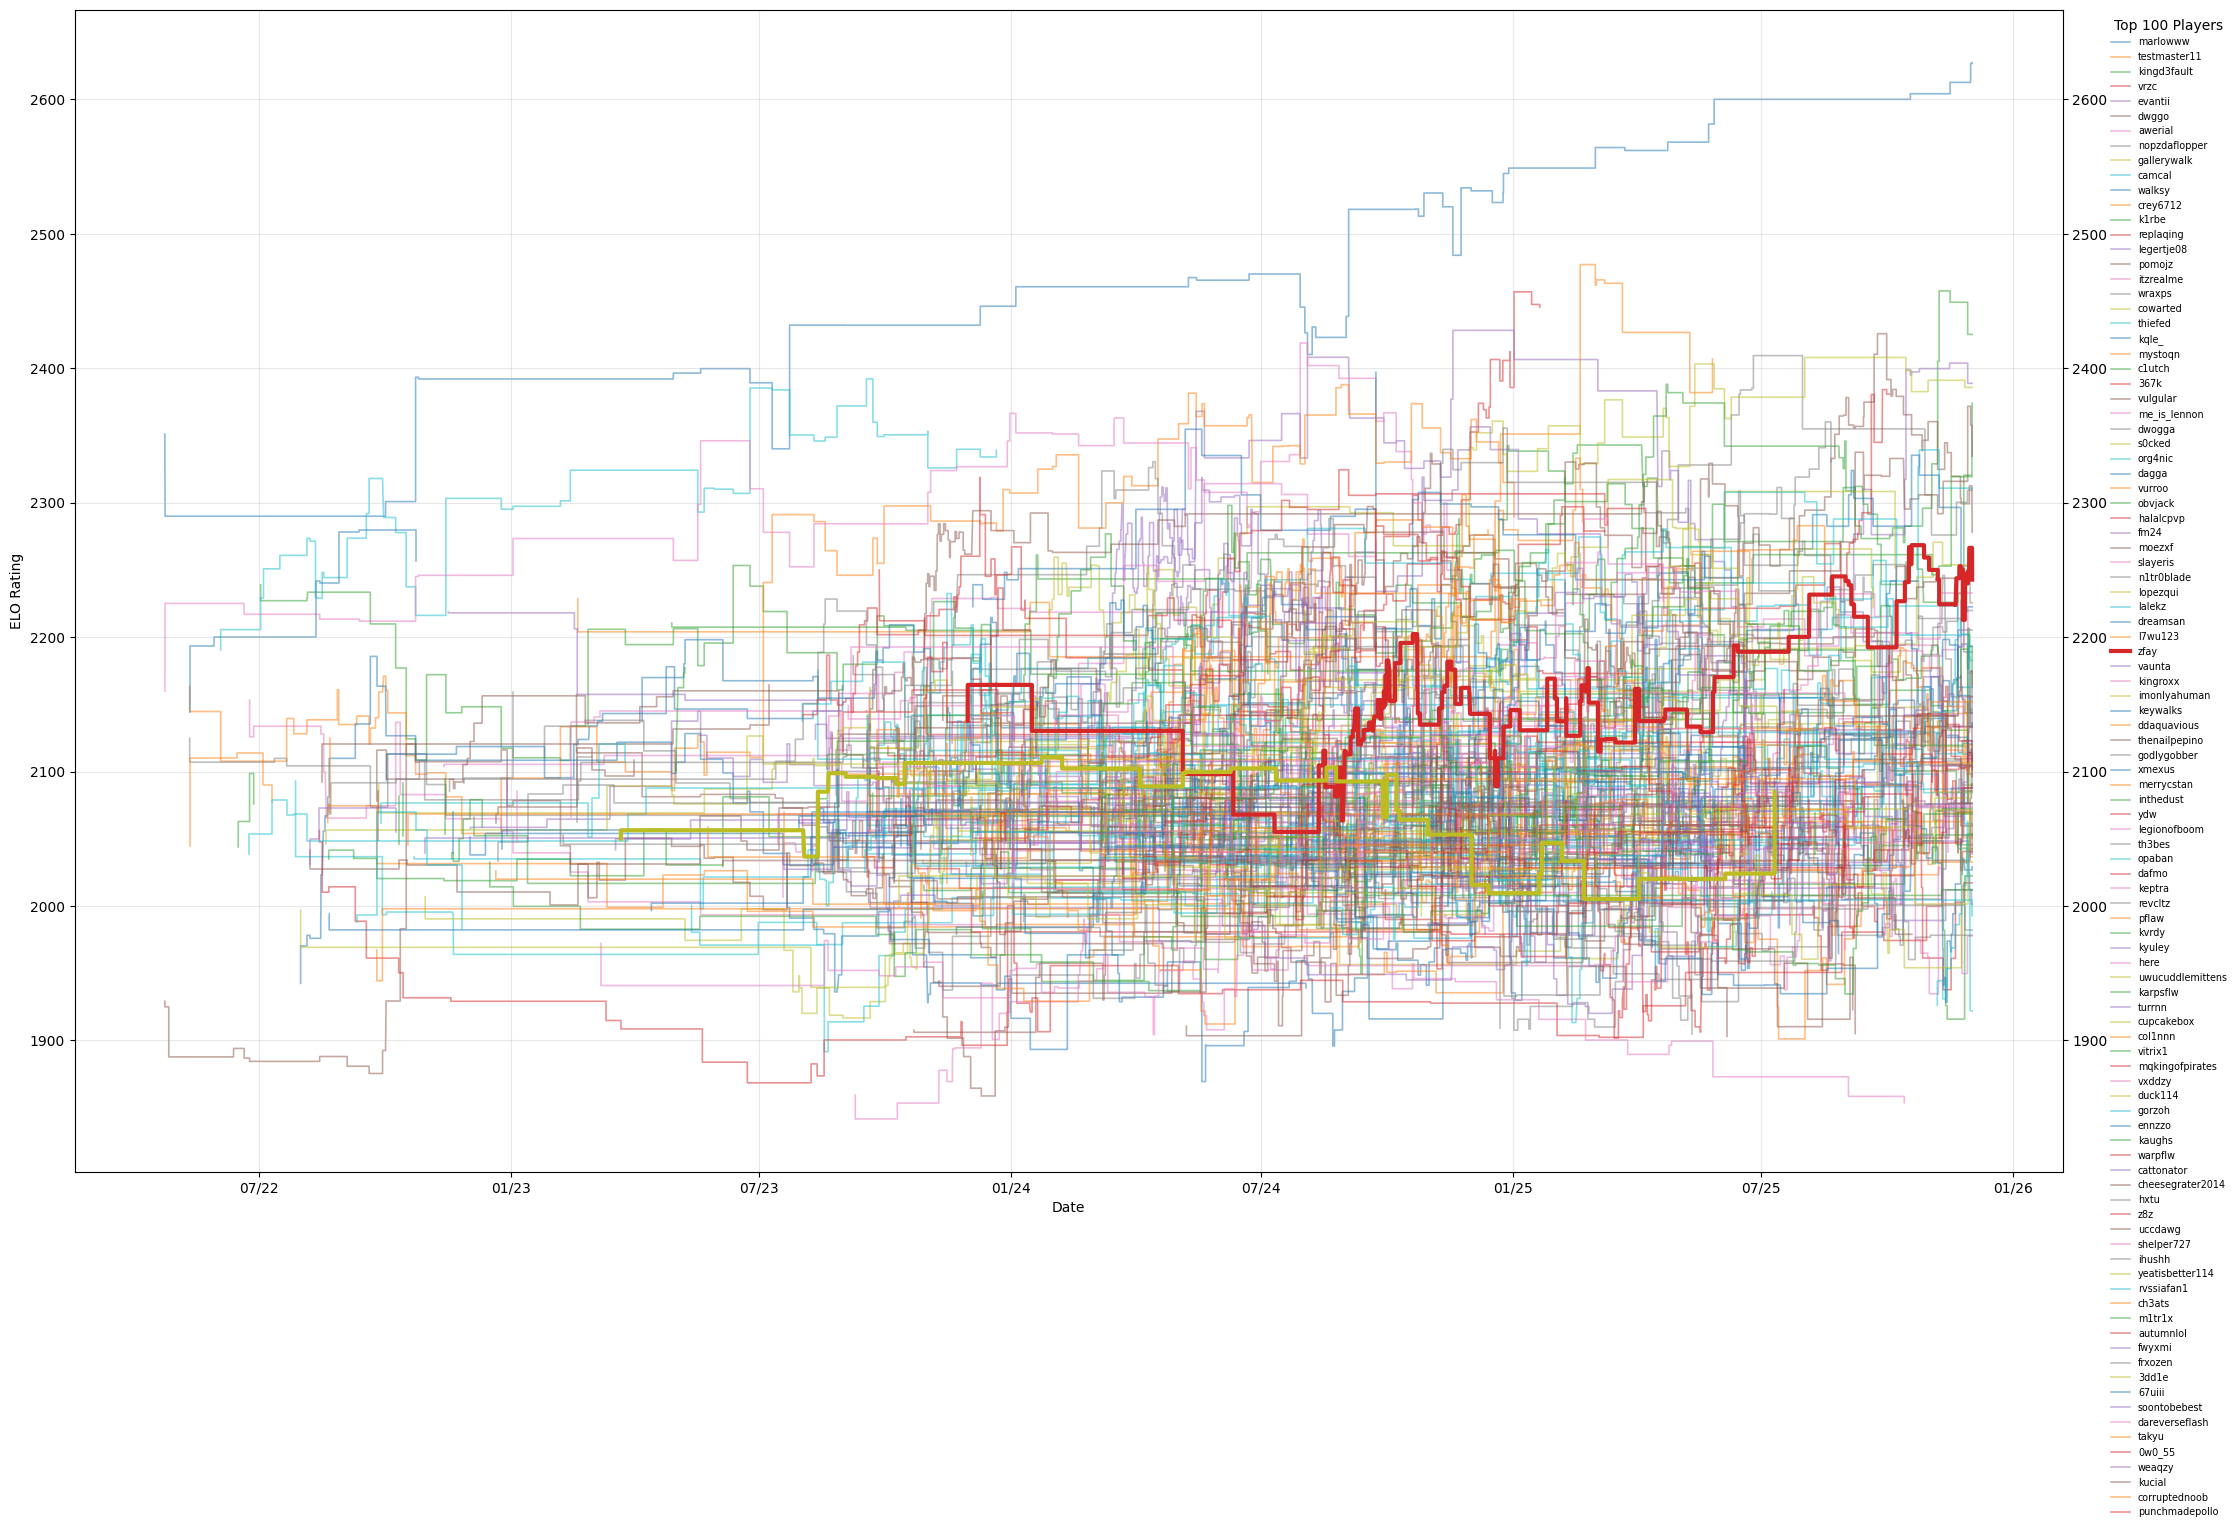

In [53]:
top_n = 500
top_players = sorted(players.items(), key=lambda kv: kv[1]["peak"], reverse=True)[:top_n]

#plot_elo_progress(dict(top_players), sample=["itzrealsme", "dreamsan", "marlowww", "crey6712", "camcal", "awerial", "evantii", "wraxps", "gallerywalk"]) # All former HT1s
#plot_elo_progress(dict(top_players), sample=["jaoling", "cowarted", "asteroides", "revcltz", "walksy", "awerial", "2sap", "replaqing", "turrnn", "me_is_lennon", "halalcpvp", "vrzc", "tokenu", "jesprr", "nopzdaflopper", "mystoqn", "vulgular", "lalekz", "daquaviousblm", "quelchi"]) # EU PLAYERS

plot_elo_progress(dict(top_players), highlight=["drdonutt", "zfay"], extend_cutoff_days=40)

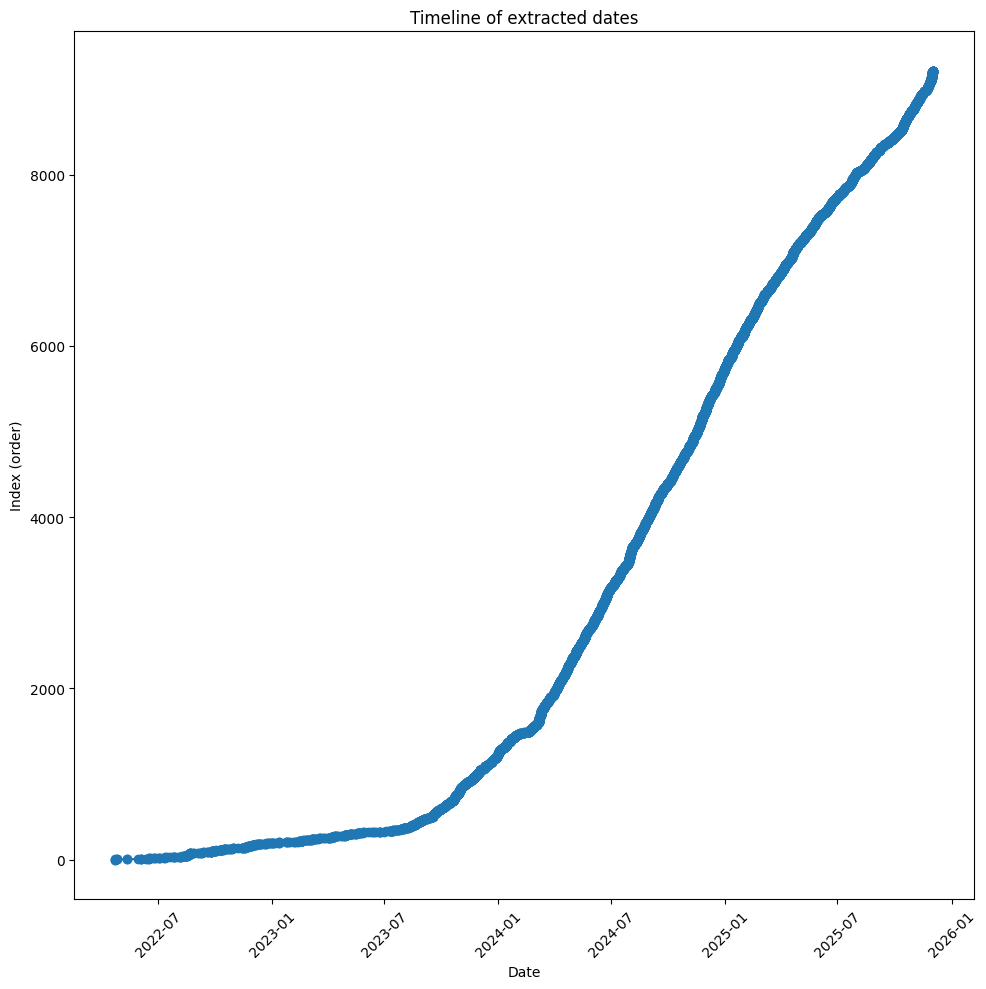

Large gaps found:
From 2022-04-23 06:20:00 to 2022-04-26 00:12:00: 2 days, 17:52:00
From 2022-04-26 00:21:00 to 2022-05-11 06:08:00: 15 days, 5:47:00
From 2022-05-11 06:08:00 to 2022-05-28 22:18:00: 17 days, 16:10:00
From 2022-05-28 22:18:00 to 2022-06-02 21:02:00: 4 days, 22:44:00
From 2022-06-04 00:15:00 to 2022-06-12 07:00:00: 8 days, 6:45:00
From 2022-06-12 07:00:00 to 2022-06-15 01:32:00: 2 days, 18:32:00
From 2022-06-15 18:12:00 to 2022-06-19 23:57:00: 4 days, 5:45:00
From 2022-06-19 23:57:00 to 2022-06-23 18:47:00: 3 days, 18:50:00
From 2022-06-23 23:09:00 to 2022-06-26 23:39:00: 3 days, 0:30:00
From 2022-06-26 23:39:00 to 2022-07-02 00:30:00: 5 days, 0:51:00
From 2022-07-02 00:30:00 to 2022-07-04 02:50:00: 2 days, 2:20:00
From 2022-07-04 02:50:00 to 2022-07-10 03:28:00: 6 days, 0:38:00
From 2022-07-12 02:26:00 to 2022-07-16 02:15:00: 3 days, 23:49:00
From 2022-07-16 02:15:00 to 2022-07-21 01:01:00: 4 days, 22:46:00
From 2022-07-21 01:01:00 to 2022-07-25 20:02:00: 4 days, 19:01:

In [52]:
# FIND LARGE TIME GAPS IN COPY PASTED DATA



import re
from datetime import datetime
import matplotlib.pyplot as plt

# Example long text (replace with your own big string)
text = data

# Step 1: Extract all dates using regex
pattern = r"\d{2}/\d{2}/\d{4}, \d{2}:\d{2}"
matches = re.findall(pattern, text)

# Step 2: Convert to datetime objects
dates = [datetime.strptime(m, "%d/%m/%Y, %H:%M") for m in matches]
dates.sort()  # sort chronologically

# Step 3: Plot the dates
plt.figure(figsize=(10, 10))
plt.plot(dates, range(len(dates)), marker="o", linestyle="-")
plt.xlabel("Date")
plt.ylabel("Index (order)")
plt.title("Timeline of extracted dates")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 4: (Optional) Check for big gaps
gaps = []
for i in range(1, len(dates)):
    delta = dates[i] - dates[i-1]
    if delta.total_seconds() > 3600 * 48:  # bigger than 1 day
        gaps.append((dates[i-1], dates[i], delta))

print("Large gaps found:")
for start, end, delta in gaps:
    print(f"From {start} to {end}: {delta}")
